In [37]:
import os
import re
import json
results = {}
with open('./results.json', 'r', encoding='utf-8') as f:
    results = json.load(f)
    
codigos = results.keys()

In [38]:

# result = { 
#     "pontuacao" : None,
#     "n_subtarefas" : None,
#     "subtarefas100" : None,
#     "tempo_lim" : None,
#     "mem_lim" : None,
#     "tempo" : None,
#     "mem" : None,
#     "comp" : None,
#     "stderr" : None 
# }
list_error = []
list_warning = []
list_accepted = []
list_TLE = []
list_MLE = []
for codigo in codigos:
    data = results[codigo]
    if not data["comp"]:
        list_error.append(codigo)
        continue
    if len(data["stderr"])>1:
        list_warning.append(codigo)
    if data["pontuacao"] == 100:
        list_accepted.append(codigo)
    if data["tempo"] >= data["tempo_lim"]:
        list_TLE.append(codigo)
    if data["mem"] >= data["mem_lim"]:
        list_MLE.append(codigo)



    
        

In [39]:

# para encontrar enunciado, considerar 'entrada' após primeira ocorrência de 'Exemplo'
for codigo in codigos:
    with open(f'./pratique/{codigo}/{codigo}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    search = re.search(r'Exemplo', text)
    if search is None:
        print(f'{codigo} sem exemplos.')
        continue
    splitted = text.split('Exemplo')
    if re.search(r'[Ee]ntrada', splitted[0]) is None or re.search(r'[Ss]a[ií]da', splitted[0]) is None:
        print(f'{codigo} com exemplo traiçoeiro.')

In [40]:
def count_words(text):
    return len(re.findall(r'\S+', text))
def get_info(info, codigo):
    info[codigo] = {
        "len_enunciado": None,
        "len_entrada": None,
        "len_saida": None,
        "n_restricoes": None,
        "n_exemplos": None
    }
    text = ''
    with open(f'./pratique/{codigo}/{codigo}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    data = info[codigo]
    enunciado, text = re.split(r'Exemplo',text,maxsplit=1) 
    sections = re.split(r'[Ee]ntrada',text)
    data["len_enunciado"] = count_words(enunciado)
    n_exemplos = len(sections)-1
    len_entrada = 0
    len_saida = 0
    if n_exemplos > 0:
        for section in sections[1:]:
            splitted = re.split(r'\n[^\n]*[Ss]a[ií]da[^\n]*\n',section) # verificado se existe string 'Saida' nos textos # verificado se as strings procuradas existem nos textos
            entrada = splitted[0]
            try:
                saida = splitted[1]
            except:
                print(f'{codigo} com erro.')
                print(section, "AAAA", splitted)
                return
            # except: # quebra em caso de entrada vazia
            #     print(f'{codigo} com entrada vazia.')
            #     return
            if len(entrada.strip()) == 0 or len(saida.strip()) == 0:
                print(f'{codigo} com entrada ou saida vazia.')
                return
            len_entrada += count_words(entrada)
            len_saida += count_words(saida)
        len_entrada /= n_exemplos
        len_saida /= n_exemplos
        data["len_entrada"] = len_entrada
        data["len_saida"] = len_saida
    data["n_exemplos"] = n_exemplos
    data["n_restricoes"] = enunciado.count('≤')+enunciado.count('≥')
info = {}
ignore = ['2011_p1_f1_pulosapo'] # foge do modelo de enunciado
for codigo in codigos:
    if codigo in ignore:
        continue
    get_info(info, codigo)

info['2011_p1_f1_pulosapo'] = {
    "len_enunciado": 357,
    "len_entrada": 8.0,
    "len_saida": 12.5,
    "n_restricoes": 4,
    "n_exemplos": 2
}
        

In [41]:
comentarios = {}
def get_comentarios(comentarios, codigo):
    with open(f'./pratique/{codigo}/{codigo}.cpp', 'r', encoding='utf-8') as f:
        code = f.read()
    search = re.findall(r'(//.*?$|/\*.*?\*/)', code, re.DOTALL | re.MULTILINE)
    if len(search) > 0:
        comentarios[codigo] = search
for codigo in codigos:
    get_comentarios(comentarios, codigo)


In [42]:
contain_image = []
with open('./pratique/contain_image.json', 'r', encoding='utf-8') as f:
    contain_image = json.load(f)
for i in range(len(contain_image)):
    splitted = contain_image[i].split('/')
    nivel = splitted[2]
    edicao = splitted[3]
    fase = splitted[4]
    nome = splitted[5]
    contain_image[i] = f'{edicao}_{nivel}_{fase}_{nome}'

In [62]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Configurações globais para os gráficos
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# Convertendo os dicionários em DataFrames para facilitar a análise
results_df = pd.DataFrame.from_dict(results, orient="index")
info_df = pd.DataFrame.from_dict(info, orient="index")

# Unindo os dois DataFrames
df = results_df.join(info_df)
df["edicao"] = df.index.str.split("_").str[0]
df["nivel"] = df.index.str.split("_").str[1]
df["fase"] = df.index.str.split("_").str[2]
df["contain_image"] = df.index.isin(contain_image)
df.loc[(df["comp"]==False), "pontuacao"] = 0
# Valid df: compilation success, not TLE, not MLE
# Use .loc[] to create the new column
bins = [0, 200, 400, np.inf]
labels = ["<=200", "<=400", ">400"]
df.loc[:, 'len_enunciado_group'] = pd.cut(
    df['len_enunciado'],
    bins=bins,
    labels=labels,
    right=True
)
df_comp = df[(df["comp"] == True)]



bins = [0, 5, 10, np.inf]
labels = ["1-5", "6-10", "11+"]


# Use .loc[] to create the new column
df_comp.loc[:, 'n_subtarefas_group'] = pd.cut(
    df_comp['n_subtarefas'],
    bins=bins,
    labels=labels,
    right=True
)





df_noerror = df_comp[(~df_comp.index.isin(list_TLE)) & (~df_comp.index.isin(list_MLE))]
df_TLE = df_comp[(df_comp.index.isin(list_TLE))]
df_MLE = df_comp[(df_comp.index.isin(list_MLE))]
df_image = df[df["contain_image"] == True]
df_noimage = df[df["contain_image"] == False]



C:\Users\analc\AppData\Local\Temp\ipykernel_17016\891648878.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp.loc[:, 'n_subtarefas_group'] = pd.cut(


                           pontuacao  n_subtarefas  subtarefas100  tempo_lim  \
2021_p2_f1_idade                70.0          10.0            7.0        0.1   
2017_p1_f3_bits                  0.0           5.0            0.0        0.1   
2016_p1_f2_caminhos-reino        0.0           5.0            0.0        0.1   
2020_p2_f1_fissura              20.0           5.0            1.0        0.1   
2017_p2_f1_botas               100.0           4.0            4.0        0.1   
...                              ...           ...            ...        ...   
2019_pj_f1_secreta              20.0           5.0            1.0        0.1   
2017_p2_f2_mapa                  0.0           5.0            0.0        0.1   
2015_p1_f1_arquivos              0.0           4.0            0.0        0.1   
2017_p1_f2_tabuleiro             0.0           4.0            0.0        0.1   
2021_ps_f2_senha                 0.0           NaN            NaN        NaN   

                             mem_lim  t

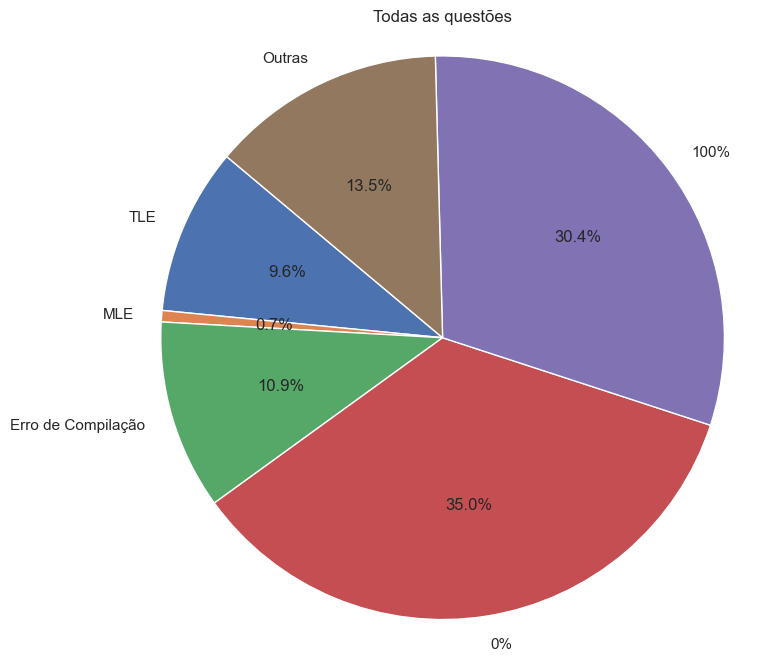

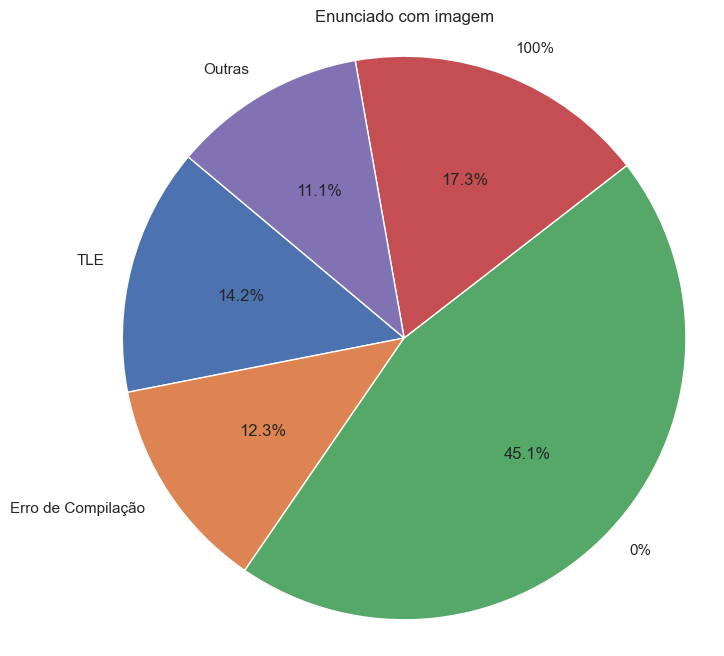

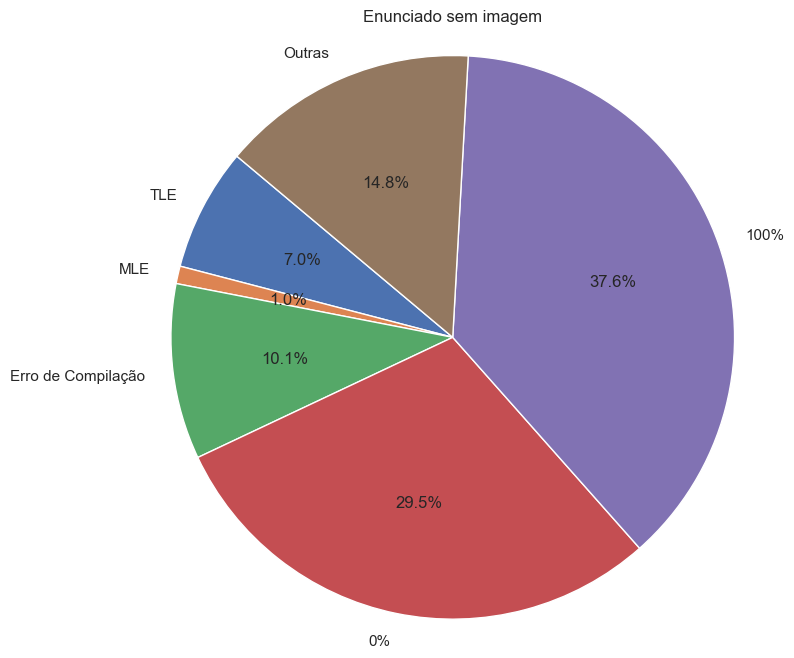

In [114]:


def plot_pie(df, title):
    """Helper function to generate a pie chart."""
    comp_false = (df["comp"]==False).sum()
    tle = (df.index.isin(list_TLE)).sum()
    mle = (df.index.isin(list_MLE)).sum()
    score0 = ((df["comp"]==True) & (~df.index.isin(list_TLE)) & (~df.index.isin(list_MLE)) & (df["pontuacao"]==0)).sum()
    score100 = (df["pontuacao"]==100).sum()
    other = len(df) - score100 - score0 - comp_false - tle - mle

    labels = [ "TLE", "MLE", "Erro de Compilação", "0%", "100%", "Outras"]
    sizes = [tle, mle, comp_false, score0, score100, other]
    
    if mle == 0:
        labels.pop(1)
        sizes.pop(1)

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_pie(df, "Todas as questões")
plot_pie(df_image, "Enunciado com imagem")
plot_pie(df_noimage, "Enunciado sem imagem")
# incluir pontuacao media por categoria



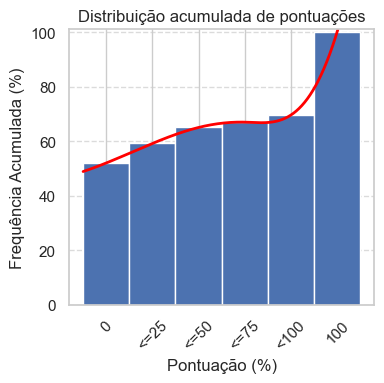

In [122]:
def plot_cdf(pontuacoes):
    bins = [0, 25, 50, 75, 100]
    labels = ['0', '<=25', '<=50', '<=75', '<100', '100']

    counts = [
        (pontuacoes == 0).sum(),
        ((pontuacoes > 0) & (pontuacoes <= 25)).sum(),
        ((pontuacoes > 25) & (pontuacoes <= 50)).sum(),
        ((pontuacoes > 50) & (pontuacoes <= 75)).sum(),
        ((pontuacoes > 75) & (pontuacoes < 100)).sum(),
        (pontuacoes == 100).sum()
    ]

    total_count = len(pontuacoes)
    percentages = [count / total_count * 100 for count in counts]
    cumulative_percentages = np.cumsum(percentages)

    # Create the plot
    plt.figure(figsize=(4, 4))

    # Bar plot (thinner and glued together)
    bar_width = 1 
    bar_positions = np.arange(len(labels)) 

    plt.bar(bar_positions, cumulative_percentages, width=bar_width, align='edge')

    # Ensure the last bin is included properly in the spline interpolation
    x_vals = bar_positions + bar_width / 2  # Adjust x positions
    y_vals = cumulative_percentages

    # Smooth trend curve using spline interpolation
    x_smooth = np.linspace(bar_positions.min(), bar_positions.max() + bar_width, 300)
    spl = make_interp_spline(x_vals, y_vals, k=3)  # k=3 for cubic spline
    y_smooth = spl(x_smooth)

    plt.plot(x_smooth, y_smooth, color='red', linestyle='-', linewidth=2)

    # Set labels and title
    plt.ylim(0, 101)
    plt.xlabel("Pontuação (%)")
    plt.ylabel("Frequência Acumulada (%)")
    plt.title("Distribuição acumulada de pontuações")
    plt.xticks(bar_positions + bar_width / 2, labels, rotation=45)  # Adjust xtick positions
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
pontuacoes = df["pontuacao"]
plot_cdf(pontuacoes)

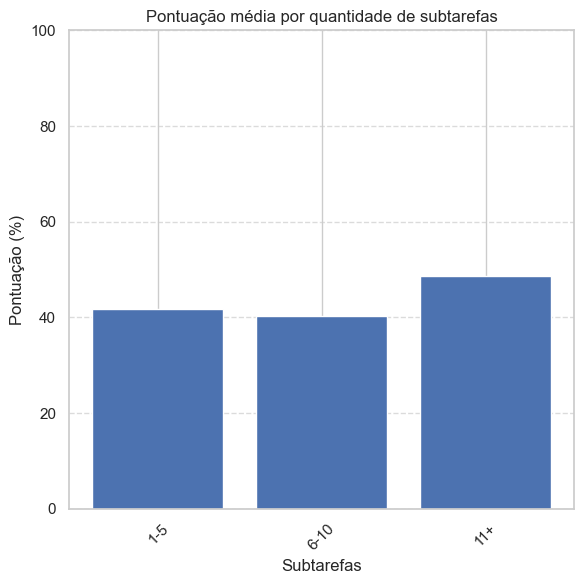

In [116]:
# 2) Porcentagens de acertos por quantidade de subtarefas
niveis = ['pj', 'p1', 'p2', 'ps']
fases = ['f1', 'f2', 'f3']
def get_percentage(df, column, value):
    total_count = len(df)
    count = (df[column] == value).sum()
    return (count / total_count) * 100 if total_count > 0 else 0
def plot1(labels, values, colors, title, xlabel, ylabel, ylim=None, line=False):
    plt.figure(figsize=(6, 6))
    if ylim:
        plt.ylim(0, ylim)
    
    if not line:
        if colors is None:
            plt.bar(labels, values)
        else:
            plt.bar(labels,values,color=colors)
    else:
        plt.plot(labels, values, linestyle='-', marker='o')
   
    plt.xticks(rotation=45)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
def plot_media1(df, column, title, xlabel, ylabel, ylim=None, percentage=False):
    values = []
    
    labels = ['Geral', 'Nível Júnior', 'Nível 1', 'Nível 2', 'Nível Sênior', 'Fase 1', 'Fase 2', 'Fase 3']
    colors = ['red', 'blue', 'blue', 'blue', 'blue', 'green', 'green', 'green']
    if not percentage:
        values.append(df[column].mean())
        for nivel in niveis:
            values.append(df[df['nivel'] == nivel][column].mean())
        for fase in fases:
            values.append(df[df['fase'] == fase][column].mean())
    
    else:
        values.append(get_percentage(df, column, 100))
        for nivel in niveis:
            values.append(get_percentage(df[df['nivel'] == nivel], column, 100))
        for fase in fases:
            values.append(get_percentage(df[df['fase'] == fase], column, 100))
            
    plot1(labels, values, colors, title, xlabel, ylabel, ylim)
    
def plot_media2(df, group, groups, column, title, xlabel, ylabel, ylim=None, line=False):
    values = []
    
    for gr in groups:
        values.append(df[df[group] == gr][column].mean())
          
    plot1(groups, values, None, title, xlabel, ylabel, ylim, line)


plot_media2(df_comp, "n_subtarefas_group", ["1-5", "6-10", "11+"], "pontuacao", "Pontuação média por quantidade de subtarefas", "Subtarefas", "Pontuação (%)", ylim=100)


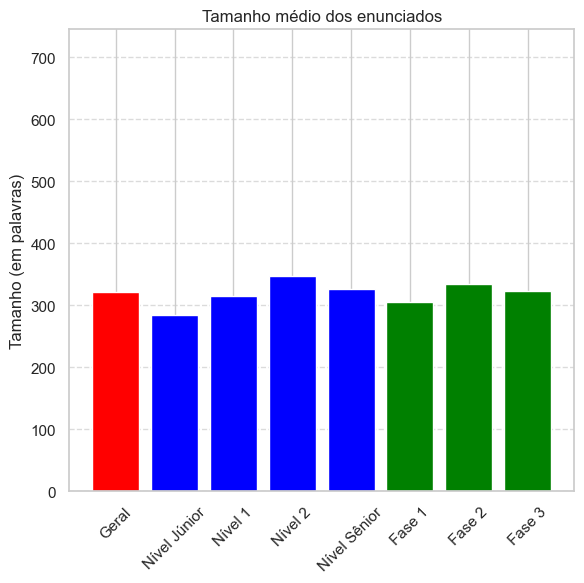

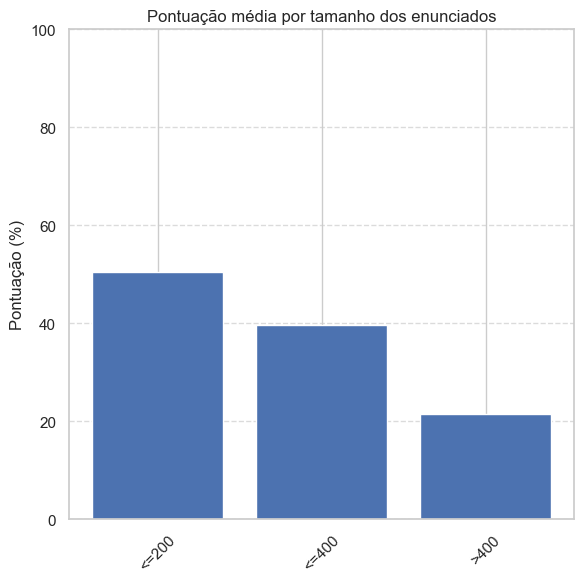

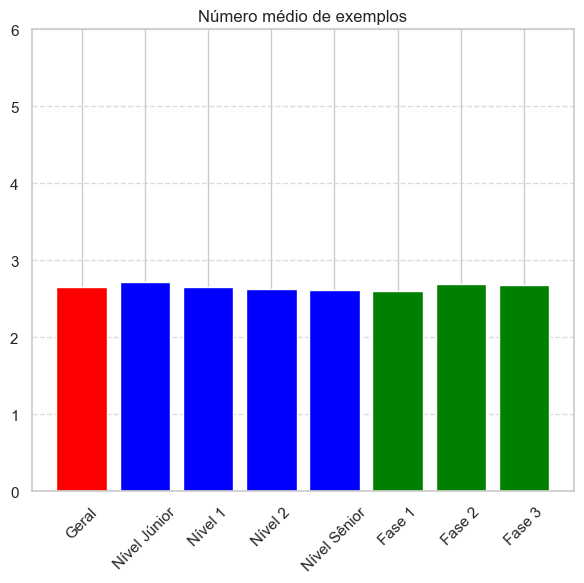

In [117]:
plot_media1(df, "len_enunciado", "Tamanho médio dos enunciados", None, "Tamanho (em palavras)", ylim=df['len_enunciado'].max())
plot_media2(df, "len_enunciado_group", ["<=200", "<=400", ">400"], "pontuacao", "Pontuação média por tamanho dos enunciados", None, "Pontuação (%)", ylim=100)
plot_media1(df, "n_exemplos", "Número médio de exemplos", None, None, ylim=df['n_exemplos'].max())
#

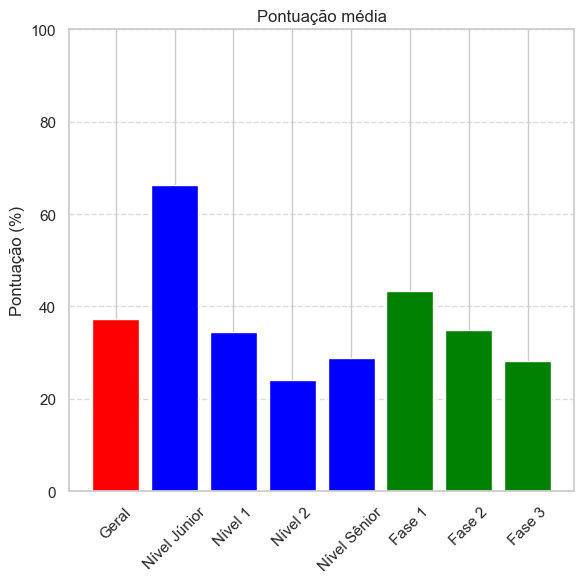

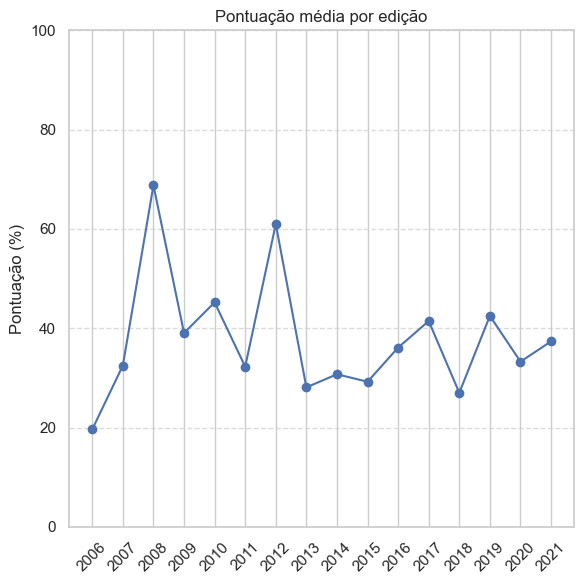

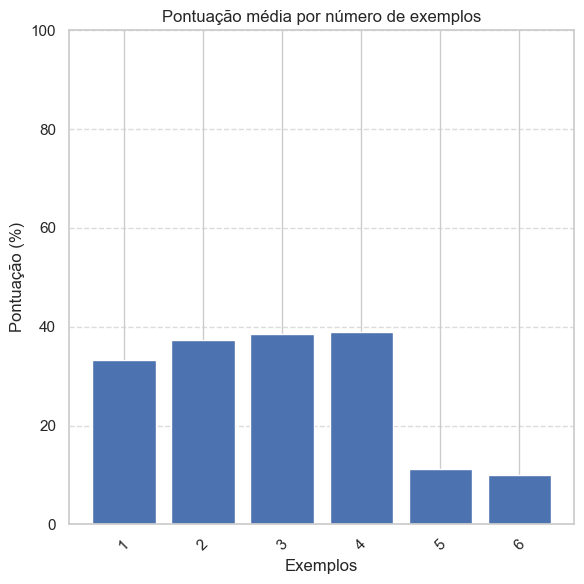

In [118]:
#4
plot_media1(df, "pontuacao", "Pontuação média", None, "Pontuação (%)", ylim=100)

plot_media2(df, "edicao", sorted(df["edicao"].unique().tolist()), "pontuacao", "Pontuação média por edição", None, "Pontuação (%)",  100,True)
plot_media2(df, "n_exemplos", sorted(df["n_exemplos"].unique().tolist()), "pontuacao", "Pontuação média por número de exemplos", "Exemplos","Pontuação (%)", ylim=100)
# efeito da baixa amostra de exercicios de nivel universitario

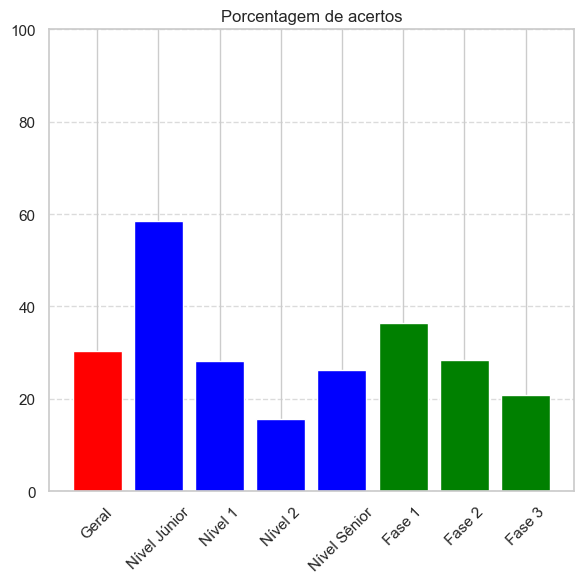

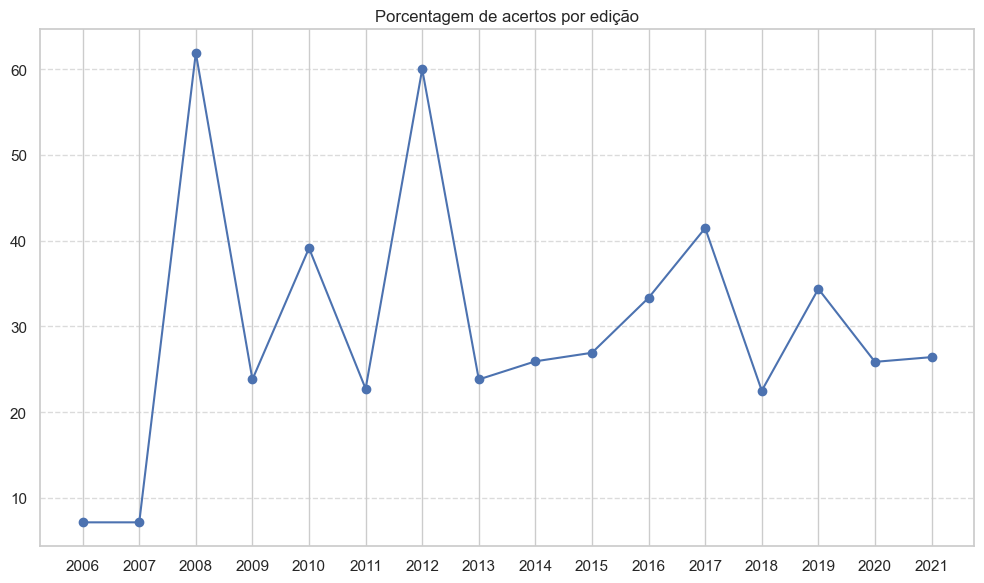

In [119]:
#6
plot_media1(df, "pontuacao", "Porcentagem de acertos", None, None, ylim=100, percentage=True)
labels = sorted(df["edicao"].unique().tolist())
percentages = []
for edicao in labels:
    new_df = df[df["edicao"] == edicao]
    total_count = len(new_df)
    count = (new_df["pontuacao"] == 100).sum()
    percentages.append((count / total_count) * 100 if total_count > 0 else 0)
  
plt.figure(figsize=(10, 6))
plt.plot(labels, percentages, marker='o', linestyle='-') 
plt.title("Porcentagem de acertos por edição")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

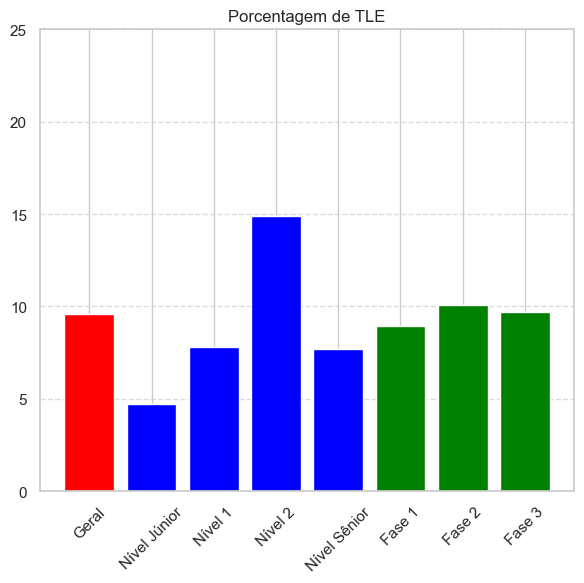

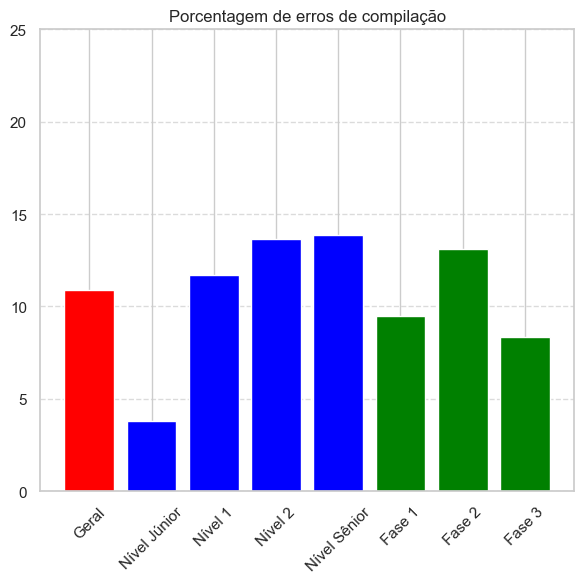

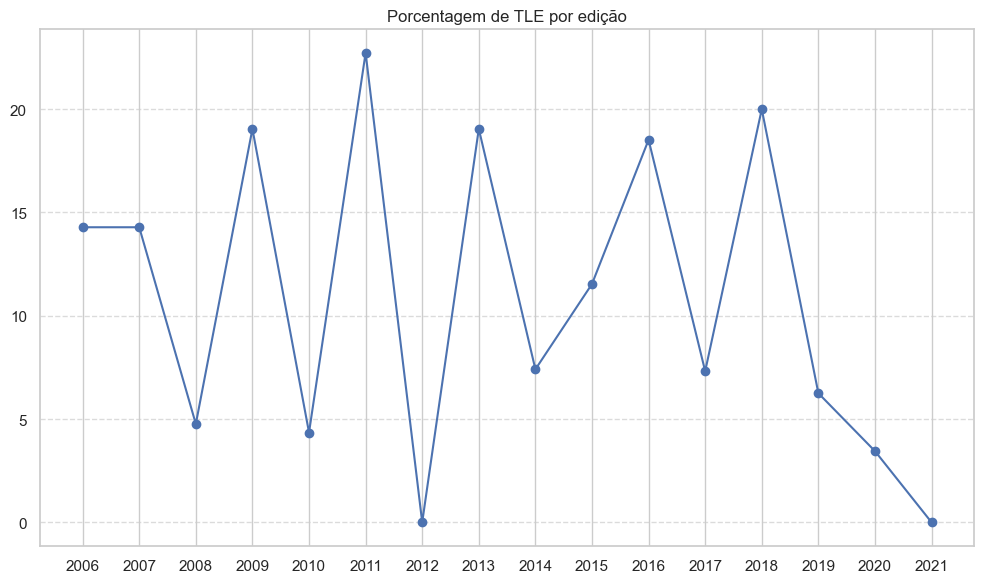

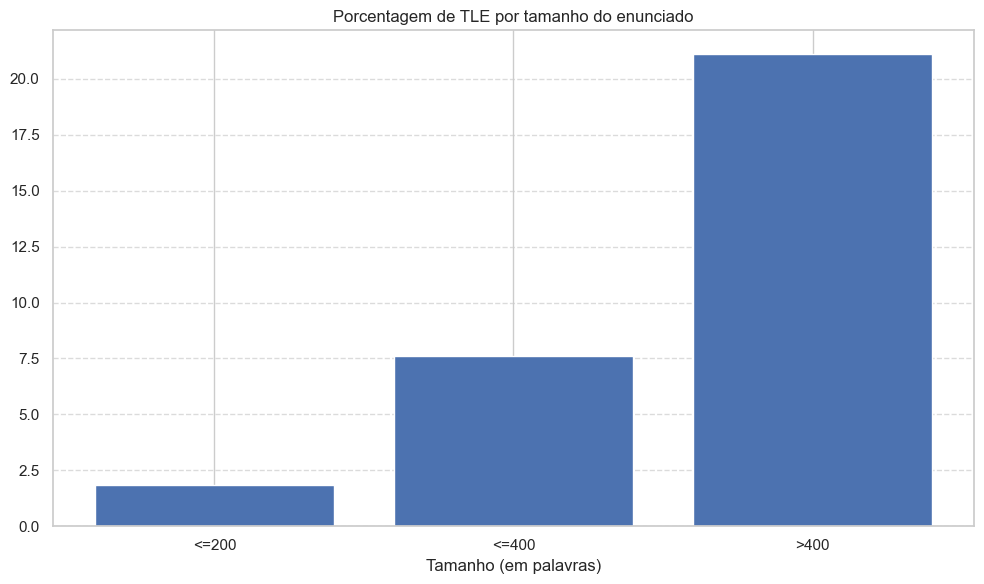

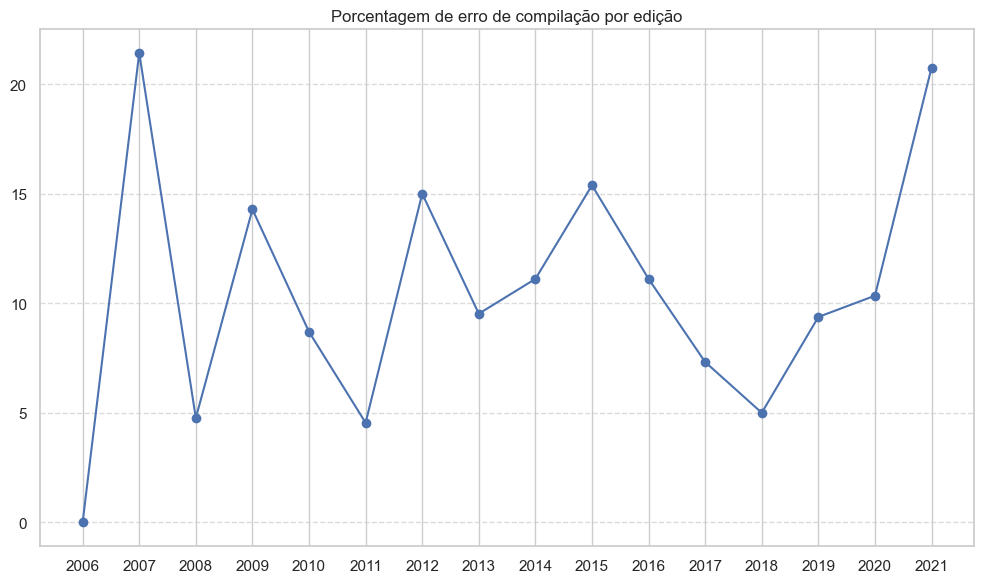

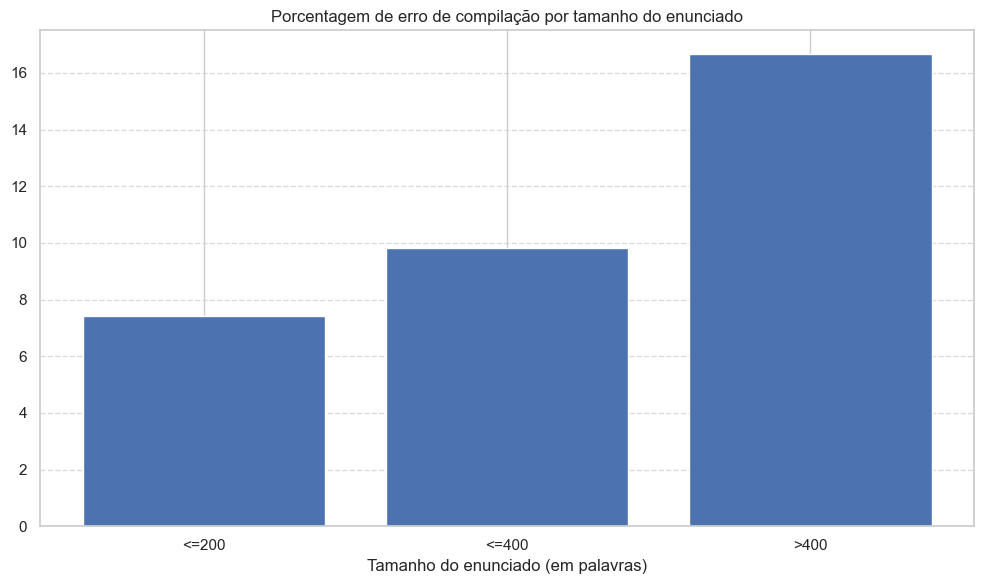

In [120]:
#5 # entre as solucoes executadas
def calculate_percentage_isin(df, list):
    values=[]
    total_count = len(df)
    count = (df.index.isin(list)).sum()
    values.append((count / total_count) * 100 if total_count > 0 else 0)
    for nivel in niveis:
        new_df = df[df['nivel'] == nivel]
        total_count = len(new_df)
        count = (new_df.index.isin(list)).sum()
        values.append((count / total_count) * 100 if total_count > 0 else 0)
    for fase in fases:
        new_df = df[df['fase'] == fase]
        total_count = len(new_df)
        count = (new_df.index.isin(list)).sum()
        values.append((count / total_count) * 100 if total_count > 0 else 0)
    return values

def calculate_percentage_error(df):
    values=[]
    total_count = len(df)
    count = (df["comp"]==False).sum()
    values.append((count / total_count) * 100 if total_count > 0 else 0)
    for nivel in niveis:
        new_df = df[df['nivel'] == nivel]
        total_count = len(new_df)
        count = (new_df["comp"]==False).sum()
        values.append((count / total_count) * 100 if total_count > 0 else 0)
    for fase in fases:
        new_df = df[df['fase'] == fase]
        total_count = len(new_df)
        count = (new_df["comp"]==False).sum()
        values.append((count / total_count) * 100 if total_count > 0 else 0)
    return values

labels = ['Geral', 'Nível Júnior', 'Nível 1', 'Nível 2', 'Nível Sênior', 'Fase 1', 'Fase 2', 'Fase 3']
colors = ['red', 'blue', 'blue', 'blue', 'blue', 'green', 'green', 'green']
plot1(labels, calculate_percentage_isin(df, list_TLE), colors, "Porcentagem de TLE", None, None, 25)
plot1(labels, calculate_percentage_error(df), colors, "Porcentagem de erros de compilação", None, None, 25)

labels = sorted(df["edicao"].unique().tolist())
percentages = []
for edicao in labels:
    new_df = df[df["edicao"] == edicao]
    total_count = len(new_df)
    count = (new_df.index.isin(list_TLE)).sum()
    percentages.append((count / total_count) * 100 if total_count > 0 else 0)
  
plt.figure(figsize=(10, 6))
plt.plot(labels, percentages, marker='o', linestyle='-') 
plt.title("Porcentagem de TLE por edição")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


labels = ["<=200", "<=400", ">400"]
percentages = []
for group in labels:
    new_df = df[df["len_enunciado_group"] == group]
    total_count = len(new_df)
    count = (new_df.index.isin(list_TLE)).sum()
    percentages.append((count / total_count) * 100 if total_count > 0 else 0)
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages)
plt.xlabel("Tamanho (em palavras)")
plt.title("Porcentagem de TLE por tamanho do enunciado")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



labels = sorted(df["edicao"].unique().tolist())
percentages = []
for edicao in labels:
    new_df = df[df["edicao"] == edicao]
    total_count = len(new_df)
    count = (new_df["comp"]==False).sum()
    percentages.append((count / total_count) * 100 if total_count > 0 else 0)
plt.figure(figsize=(10, 6))
plt.plot(labels, percentages, marker='o', linestyle='-') 
plt.title("Porcentagem de erro de compilação por edição")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

labels = ["<=200", "<=400", ">400"]
percentages = []
for group in labels:
    new_df = df[df["len_enunciado_group"] == group]
    total_count = len(new_df)
    count = (new_df["comp"]==False).sum()
    percentages.append((count / total_count) * 100 if total_count > 0 else 0)
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages)
plt.xlabel("Tamanho do enunciado (em palavras)")
plt.title("Porcentagem de erro de compilação por tamanho do enunciado")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
enunciados = [info[codigo]['len_enunciado'] for codigo in codigos]
print(max(enunciados))
print(min(enunciados))
entradas = [info[codigo]['len_entrada'] for codigo in codigos]
print(max(entradas))
print(min(entradas))
saidas = [info[codigo]['len_saida'] for codigo in codigos]
print(max(saidas))
print(min(saidas))
exemplos = [info[codigo]['n_exemplos'] for codigo in codigos]
print(max(exemplos))
print(min(exemplos))

745
122
225.0
1.0
45.333333333333336
1.0
6
1
